In [36]:
#General imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

#Project specific imports
from IPython.display import Image
from sklearn.model_selection import *
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tqdm import tqdm
from PIL import ImageFile
from keras.preprocessing import image 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, InputLayer
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.applications import vgg16
from keras.utils import np_utils
import keras
import hashlib
import seaborn as sns

#displays non-truncated dataframes
pd.set_option('display.max_colwidth', -1)


### Loading in the data

In [73]:
curr_direc = os.getcwd()
full_path_to_data = curr_direc + "/data/All_VialImages/"
file_path = []
NDC = []

# Create a list of filenames and a list of pill type from the image data
# Info: The beginning part of the filename indicates the type of pill is in the image.
for f in os.listdir(full_path_to_data):
    file_path.append(os.path.join(full_path_to_data,f))
    NDC.append(f.split('_')[0])

#Put list into dataframe
image_df = pd.DataFrame(list(zip(file_path, NDC)), columns =['file_path', 'NDC']) 
display(image_df.head(10))


,file_path,NDC
0,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_335593499-2_1.jpg,00527260143
1,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_341371214-1_1.jpg,00527260143
2,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343129722-1_1.jpg,00527260143
3,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343141651-1_1.jpg,00527260143
4,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343205849-1_1.jpg,00527260143
5,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343266628-1_1.jpg,00527260143
6,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343321736-2_1.jpg,00527260143
7,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343342407-1_1.jpg,00527260143
8,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343411074-1_1.jpg,00527260143
9,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343428881-1_1.jpg,00527260143


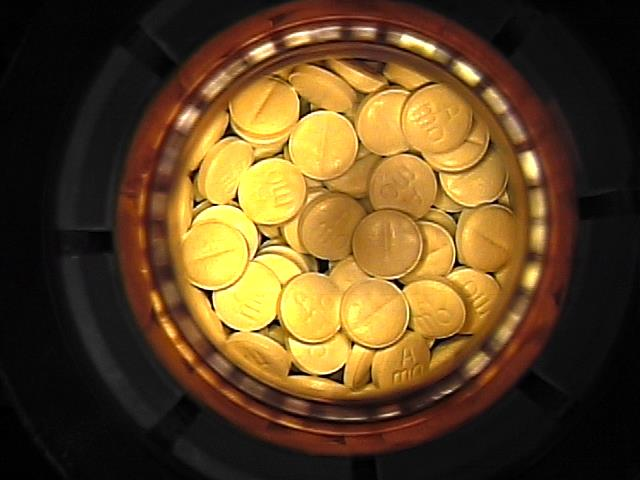

In [4]:
#Display a sample image data
Image(filename=image_df.file_path[34]) 


### Finding duplicate images (even though their filenames may be different)

In [5]:
#Calculates MD5 hash of a file
def hashfile(path, blocksize = 65536):
    afile = open(path, 'rb')
    hasher = hashlib.md5()
    buf = afile.read(blocksize)
    while len(buf) > 0:
        hasher.update(buf)
        buf = afile.read(blocksize)
    afile.close()
    return hasher.hexdigest()

#Traverse directory and compare hashes
def findDup(parentFolder):
    # Dups in format {hash:[names]}
    dups = {}
    for dirName, subdirs, fileList in os.walk(parentFolder):
        print('Scanning %s...' % dirName)
        for filename in fileList:
            # Get the path to the file
            path = os.path.join(dirName, filename)
            # Calculate hash
            file_hash = hashfile(path)
            # Add or append the file path
            if file_hash in dups:
                dups[file_hash].append(path)
            else:
                dups[file_hash] = [path]
    return dups

# Joins two dictionaries
def joinDicts(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = dict1[key] + dict2[key]
        else:
            dict1[key] = dict2[key]

# Print duplicate results
def printResults(dict1):
    results = list(filter(lambda x: len(x) > 1, dict1.values()))
    if len(results) > 0:
        print('Duplicates Found:')
        print('The following files are identical. The name could differ, but the content is identical')
        print('___________________')
        for result in results:
            for subresult in result:
                print('\t\t%s' % subresult)
            print('___________________')
 
    else:
        print('No duplicate files found.')
        

In [6]:
dups = {}
if os.path.exists(full_path_to_data):
    # Find the duplicated files and append them to the dups
    joinDicts(dups, findDup(full_path_to_data))
else:
    print('is not a valid path, please verify')
    sys.exit()
printResults(dups)

Scanning /mnt/azureblobshare/AIPV/data/All_VialImages/...
No duplicate files found.


### Distribution analysis

In [74]:
#Sort pill type by highest frequency
pill_count_df = image_df.groupby('NDC').file_path \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
display(pill_count_df)
len(pill_count_df)

,NDC,count
0,00527260143,8181
8,68382041205,4057
4,49483062401,3511
1,00591554310,397
2,00781223410,349
7,65862052899,349
9,68382066205,327
6,55111039905,204
3,43547040350,79
5,50111091703,46


10

In [75]:
#We'll use NDC column as multi-class label, and create one with binary label that focuses on a particular pill
binary_labels = []

#create binary labels for a particular pill
# 1=image contains particular pill 0=image does not contain particular pill
for NDC in image_df.NDC:
    binary_label = 0
    if NDC == '49483062401':
        binary_label = 1
    binary_labels.append(binary_label)
    
if 'binary_label' not in image_df:
    image_df.insert(2, "binary_label", binary_labels, True)

#Encode NDC labels as categorical id
image_df['pill_id'] = image_df['NDC'].factorize()[0]
NDC_id_df = image_df[['NDC', 'pill_id']].drop_duplicates().sort_values('pill_id')
NDC_to_id = dict(NDC_id_df.values)
id_to_NDC = dict(NDC_id_df[['pill_id', 'NDC']].values)

#mapping of National Drug Code to Name of Drug
NDC_to_name = {'00527260143':'Metoprolol Succinate', '68382041205':'Omeprazole', '49483062401':'Metformin Hydrochloride Extended Release'}

print(image_df.shape)
display(image_df.head(10))


(17500, 4)


,file_path,NDC,binary_label,pill_id
0,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_335593499-2_1.jpg,00527260143,0,0
1,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_341371214-1_1.jpg,00527260143,0,0
2,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343129722-1_1.jpg,00527260143,0,0
3,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343141651-1_1.jpg,00527260143,0,0
4,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343205849-1_1.jpg,00527260143,0,0
5,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343266628-1_1.jpg,00527260143,0,0
6,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343321736-2_1.jpg,00527260143,0,0
7,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343342407-1_1.jpg,00527260143,0,0
8,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343411074-1_1.jpg,00527260143,0,0
9,/mnt/azureblobshare/AIPV/data/All_VialImages/00527260143_343428881-1_1.jpg,00527260143,0,0


### Splitting the data

In [76]:
features = image_df.file_path
#modify number of categories(classes) here
labels = np_utils.to_categorical(np.array(image_df['binary_label']), 2)

# set training, testing, validation set and targets
# NOTICE: I used stratify here to help distribute the labeled pill type among the sets in case of class imbalance
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=1, stratify=labels)   
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1, stratify=y_train)

train_files = X_train
valid_files = X_val
test_files = X_test

train_targets = y_train
valid_targets = y_val
test_targets = y_test

print(train_files.shape)
print(train_targets.shape)

print(valid_files.shape)
print(valid_targets.shape)

print(test_files.shape)
print(test_targets.shape)


(7855,)
(7855, 2)
(3870,)
(3870, 2)
(5775,)
(5775, 2)


### Pre-process the Data
The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 224×224 pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

(1,224,224,3).

The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

(nb_samples,224,224,3).

We rescale the images by dividing every pixel in every image by 255.

In [77]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [59]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

# save tensors to disk
np.save('saved_tensors/train_tensors_binary_49483062401.npy', train_tensors, allow_pickle = False)
np.save('saved_tensors/valid_tensors_binary_49483062401.npy', valid_tensors, allow_pickle = False)
np.save('saved_tensors/test_tensors_binary_49483062401.npy', test_tensors, allow_pickle = False)

100%|██████████| 5775/5775 [02:31<00:00, 38.14it/s]


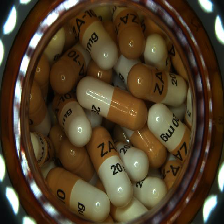

In [86]:
# load tensors from disk
train_tensors = np.load('saved_tensors/train_tensors_binary_49483062401.npy')
valid_tensors = np.load('saved_tensors/valid_tensors_binary_49483062401.npy')
test_tensors = np.load('saved_tensors/test_tensors_binary_49483062401.npy')

#Sample of resized image
img_sample = image.load_img(train_files[train_files.index[0]], target_size=(224, 224))
img_sample


### CNN Architecture (not using transfer learning)
#### Network architecture reasonings
The first layer, the input layer, is given images that are 224x224 dimension that uses RGB so 3 channels. I used the recommended activation function for CNNs, which is Relu. I played around with kernel_size and strides to see which one give better results while keeping number of parameters low. I decided to increase the number of filters progressively so that the network will start to filter out simple things first like edges and shapes, and then it will get more specific later on.

After every convolutional layers, I added a max-pooling layer to reduce dimensionality. It serves the purpose of reducing number of parameters as well as generalizing the filter result so that it doesn't overfit the data.

Another method of preventing overfit and regularization is by using dropout layers. This effectively prevent the network from playing 'favorites' as it goes through epochs.

Lastly, I added a Dense layer with softmax activation function as the output layer. The number of nodes is equal to the number of classes (i.e. 3 pill types).

In [79]:
model = Sequential()

### Define architecture.
model.add(Conv2D(filters=17, kernel_size=3, strides=1, activation='relu', padding="same", input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=51, kernel_size=3, strides=1, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=77, kernel_size=3, strides=1, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=107, kernel_size=3, strides=1, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.7))

model.add(Flatten())
#modify output size of dense to match number of categories here
model.add(Dense(2, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 17)      476       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 17)      0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 112, 112, 17)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 51)      7854      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 51)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 56, 56, 51)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 77)        35420     
__________

### Training the model

In [62]:
# Adjustable:
epochs = 5
batch_size = 20
optimizer = 'rmsprop'
loss = 'binary_crossentropy'

#Compiling the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#Checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#Train
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


Train on 7855 samples, validate on 3870 samples
Epoch 1/5
7855/7855 [==============================] - 8s 994us/step - loss: 0.2409 - acc: 0.9393 - val_loss: 0.1287 - val_acc: 0.9767

Epoch 00001: val_loss improved from inf to 0.12872, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/5
7855/7855 [==============================] - 7s 913us/step - loss: 0.0854 - acc: 0.9780 - val_loss: 0.1939 - val_acc: 0.9362

Epoch 00002: val_loss did not improve from 0.12872
Epoch 3/5
7855/7855 [==============================] - 7s 913us/step - loss: 0.0737 - acc: 0.9819 - val_loss: 0.2037 - val_acc: 0.9801

Epoch 00003: val_loss did not improve from 0.12872
Epoch 4/5
7855/7855 [==============================] - 7s 914us/step - loss: 0.0682 - acc: 0.9845 - val_loss: 0.1206 - val_acc: 0.9747

Epoch 00004: val_loss improved from 0.12872 to 0.12059, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/5
7855/7855 [==============================] - 7s 917us/step - loss: 0

### Model evaluation

In [80]:
#load the model with the best validaton loss during training
model.load_weights('saved_models/weights.best.from_scratch_binary_49483062401.hdf5')

#run predictions
pilltype_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
pilltype_test = np.argmax(test_targets, axis=1)

# report test accuracy
test_accuracy = 100*np.sum(np.array(pilltype_pred)==pilltype_test)/len(pilltype_pred)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 97.6277%


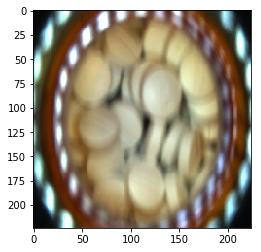

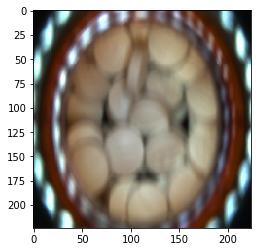

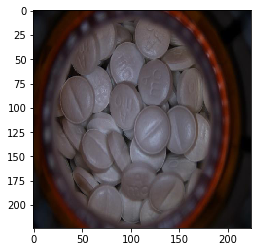

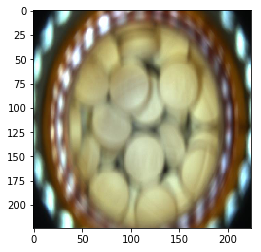

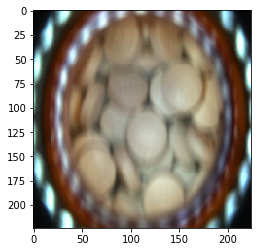

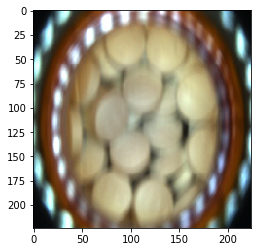

In [93]:
#For experimenting: See the images for certain predictions
counter = 0
for index, tensor in enumerate(test_tensors):
    prediction = np.argmax(model.predict(np.expand_dims(tensor, axis=0)))
    target = np.argmax(test_targets[index])
    if prediction == 1:
        if target == 0:
            arr_ = np.squeeze(tensor)
            plt.imshow(arr_)
            plt.show()
            counter = counter + 1
    
    if counter > 5:
        break
    


In [82]:
# Calculate precision, recall, f1
print(metrics.classification_report(pilltype_test, pilltype_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4616
           1       0.99      0.89      0.94      1159

   micro avg       0.98      0.98      0.98      5775
   macro avg       0.98      0.94      0.96      5775
weighted avg       0.98      0.98      0.98      5775



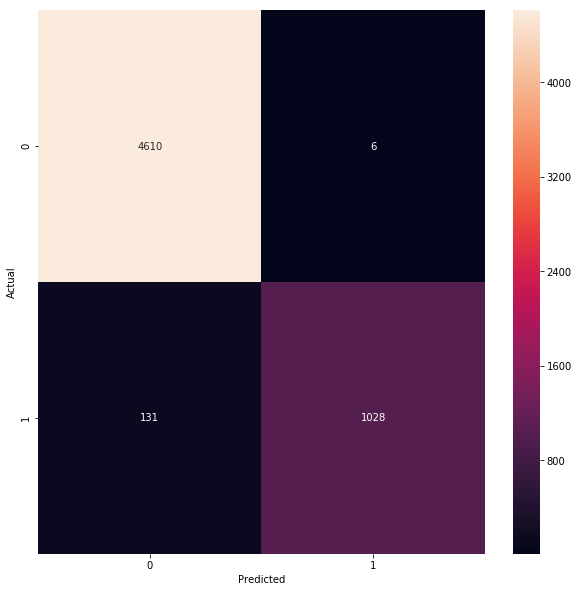

In [83]:
#plot confusion matrix
conf_mat = confusion_matrix(pilltype_test, pilltype_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
#refer to this when testing multi-class classification (not for binary classification)
display(id_to_NDC)

{0: '00527260143',
 1: '00591554310',
 2: '00781223410',
 3: '43547040350',
 4: '49483062401',
 5: '50111091703',
 6: '55111039905',
 7: '65862052899',
 8: '68382041205',
 9: '68382066205'}

### Using Transfer Learning (VGG16)
Implementations following this source: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [ ]:
input_shape = (224,224,3)
# load another pre-trained CNN.
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze pre-trained layers, we don't want their weights to change during training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])



In [ ]:
# get bottleneck features
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_tensors)
validation_features_vgg = get_bottleneck_features(vgg_model, valid_tensors)
test_features_vgg = get_bottleneck_features(vgg_model, test_tensors)

# save bottleneck features to disk
np.save('bottleneck_features/train_features_vgg.npy', train_features_vgg, allow_pickle = False)
np.save('bottleneck_features/validation_features_vgg.npy', validation_features_vgg, allow_pickle = False)
np.save('bottleneck_features/test_features_vgg.npy', test_features_vgg, allow_pickle = False)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)


In [ ]:
# load bottleneck features from disk
train_features_vgg = np.load('bottleneck_features/train_features_vgg.npy')
validation_features_vgg = np.load('bottleneck_features/validation_features_vgg.npy')
test_features_vgg = np.load('bottleneck_features/test_features_vgg.npy')

input_shape = vgg_model.output_shape[1]

# final architecture
VGG16_model = Sequential()
VGG16_model.add(InputLayer(input_shape=(input_shape,)))
VGG16_model.add(Dense(512, activation='relu', input_dim=input_shape))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Lambda(lambda x: tf.expand_dims(VGG16_model.output, axis=-1)))
VGG16_model.add(LSTM(units=64))
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(10, activation='softmax'))

VGG16_model.summary()


In [ ]:
# Adjustable:
epochs = 20
batch_size = 20
optimizer = 'rmsprop'
loss = 'categorical_crossentropy'

#Compiling the model
VGG16_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#Checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_VGG16.hdf5', 
                               verbose=1, save_best_only=True)

#Train
VGG16_model.fit(train_features_vgg, train_targets, 
          validation_data=(validation_features_vgg, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


In [ ]:
#load the model with the best validaton loss during training
VGG16_model.load_weights('saved_models/weights.best.from_VGG16.hdf5')

#run predictions
pilltype_pred = [np.argmax(VGG16_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_features_vgg]
pilltype_test = np.argmax(test_targets, axis=1)

# report test accuracy
test_accuracy = 100*np.sum(np.array(pilltype_pred)==pilltype_test)/len(pilltype_pred)
print('Test accuracy: %.4f%%' % test_accuracy)


In [ ]:
# Calculate precision, recall, f1
print(metrics.classification_report(pilltype_test, pilltype_pred))


In [ ]:
#refer to this when testing multi-class classification (not for binary classification)
display(id_to_NDC)


### Using Transfer Learning (ResNet50)

In [ ]:
input_shape = (224,224,3)
# load another pre-trained CNN.
resnet = resnet50.ResNet50(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = Model(resnet.input, output)

# Freeze pre-trained layers, we don't want their weights to change during training
resnet_model.trainable = False
for layer in resnet_model.layers:
    layer.trainable = False
    
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])


In [ ]:
# final architecture
input_shape = resnet_model.output_shape[1]

ResNet50_model = Sequential()
ResNet50_model.add(resnet_model)
ResNet50_model.add(Dense(512, activation='relu', input_dim=input_shape))
ResNet50_model.add(Dropout(0.3))
ResNet50_model.add(Dense(512, activation='relu'))
ResNet50_model.add(Dropout(0.3))
ResNet50_model.add(Dense(10, activation='softmax'))

ResNet50_model.summary()


In [ ]:
# Adjustable:
epochs = 7
batch_size = 20
optimizer = 'rmsprop'
loss = 'categorical_crossentropy'

#Compiling the model
ResNet50_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#Checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

#Train
ResNet50_model.fit(train_tensors, train_targets, 
                   validation_data=(valid_tensors, valid_targets),
                   epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)


In [ ]:
#load the model with the best validaton loss during training
ResNet50_model.load_weights('saved_models/weights.best.from_ResNet50.hdf5')

#run predictions
pilltype_pred = [np.argmax(ResNet50_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
pilltype_test = np.argmax(test_targets, axis=1)

# report test accuracy
test_accuracy = 100*np.sum(np.array(pilltype_pred)==pilltype_test)/len(pilltype_pred)
print('Test accuracy: %.4f%%' % test_accuracy)


In [ ]:
# Calculate precision, recall, f1
print(metrics.classification_report(pilltype_test, pilltype_pred))

In [ ]:
#refer to this when testing multi-class classification (not for binary classification)
display(id_to_NDC)


### Probability prediction & confidence level

In [67]:
#takes in an image path and returns categorical prediction
def predict_pill_categorical(img_path, model):
    img_tensor = path_to_tensor(img_path).astype('float32')/255
    prediction = model.predict(img_tensor)
    pill_id = []
    NDC = []
    pill_name = []
    confidence_score = []
    for index, score in enumerate(prediction[0]):
        pill_id.append(index)
        NDC_number = id_to_NDC[index]
        NDC.append(NDC_number)
        if NDC_number in NDC_to_name:
            drug_name = NDC_to_name[NDC_number]
        else:
            drug_name = "NA"
        pill_name.append(drug_name)
        confidence_score.append("{0:.7f}".format(score))
    prediction_df = pd.DataFrame(
        {'pill_id': pill_id,
         'NDC': NDC,
         'pill_name': pill_name,
         'confidence_score': confidence_score
        })
    display(prediction_df)
    display(Image(filename=img_path))
    return prediction

#takes in an image path and returns binary prediction
def predict_pill_binary(img_path, model):
    img_tensor = path_to_tensor(img_path).astype('float32')/255
    prediction = model.predict(img_tensor)
    print("Confidence level: ")
    print("{:.7f}".format(prediction[0][1]))
    display(Image(filename=img_path))
    return prediction

Confidence level: 
0.1715740


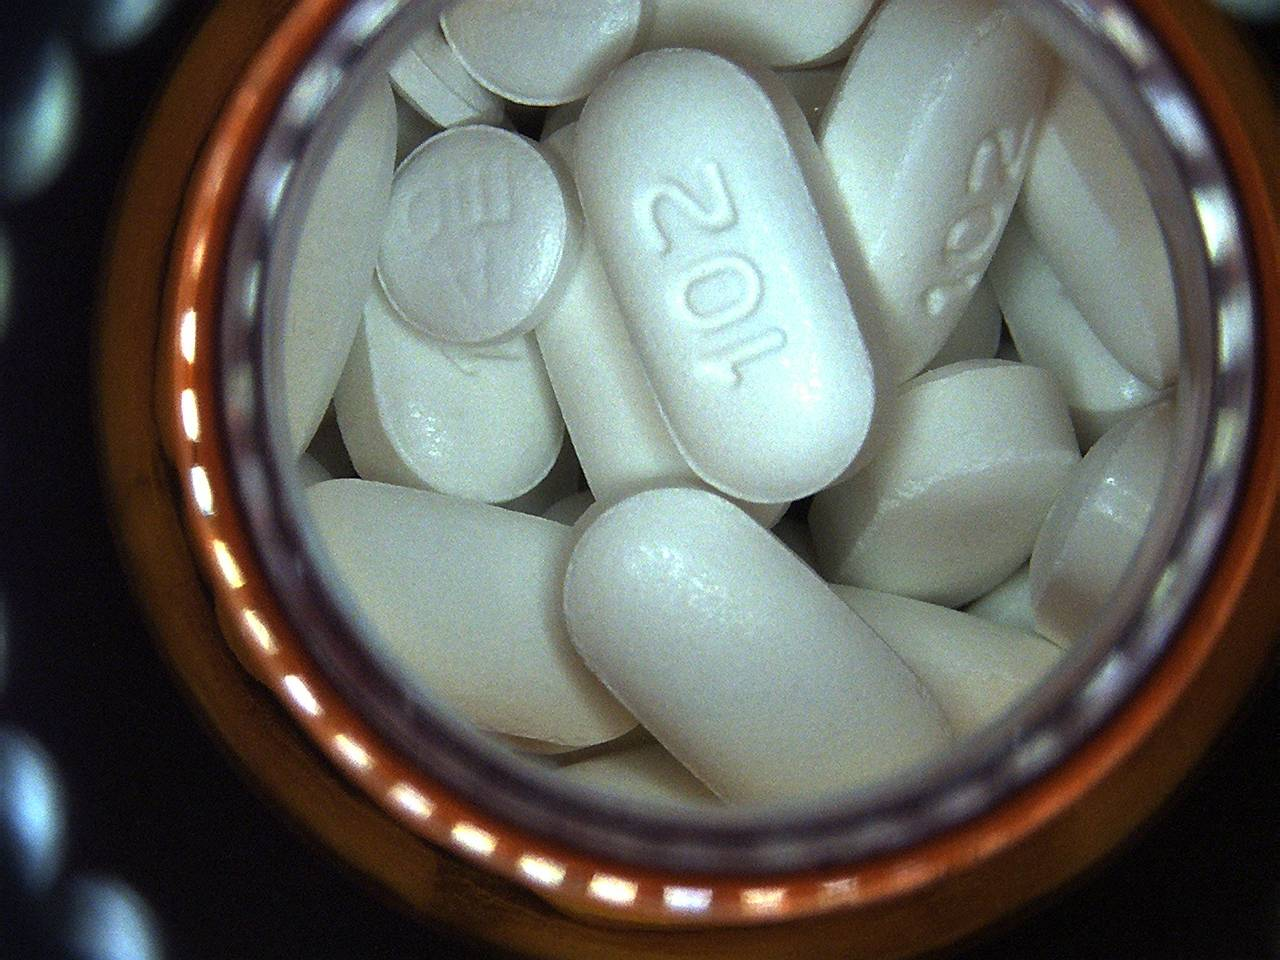

array([[0.828426  , 0.17157395]], dtype=float32)

In [91]:
#test on a specific image
curr_direc = os.getcwd()
path_to_data = curr_direc + "/data/test_images/"
filename = "49483062401_348914132-1_010201_b_mix.JPG"
img_path = path_to_data + filename

predict_pill_binary(img_path, model)


,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.0012709
1,1,00591554310,NA,0.0102925
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0014496
3,3,55111039905,NA,0.0000000
4,4,68382041205,Omeprazole,0.0000005
5,5,00781223410,NA,0.0000000
6,6,43547040350,NA,0.0000006
7,7,68382066205,NA,0.9869851
8,8,65862052899,NA,0.0000001
9,9,50111091703,NA,0.0000006


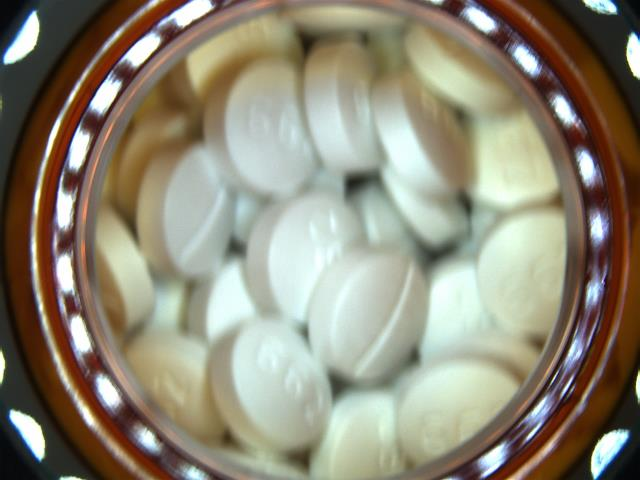

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.0003323
1,1,00591554310,NA,0.0004548
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0045287
3,3,55111039905,NA,0.0000725
4,4,68382041205,Omeprazole,0.9938299
5,5,00781223410,NA,0.0001072
6,6,43547040350,NA,0.0000006
7,7,68382066205,NA,0.0006626
8,8,65862052899,NA,0.0000109
9,9,50111091703,NA,0.0000007


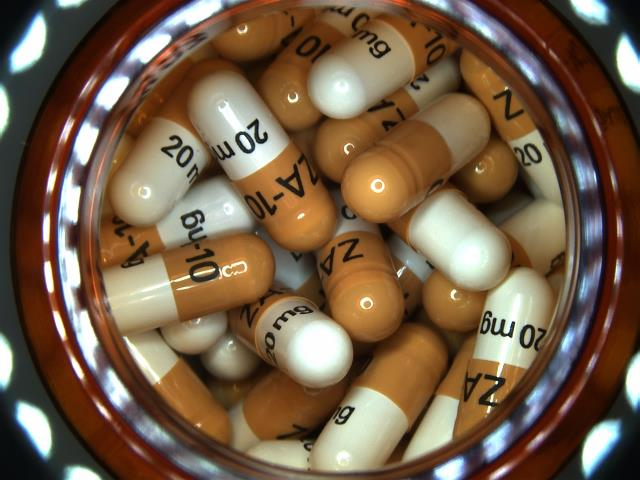

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.9980567
1,1,00591554310,NA,0.0000000
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0019427
3,3,55111039905,NA,0.0000000
4,4,68382041205,Omeprazole,0.0000000
5,5,00781223410,NA,0.0000000
6,6,43547040350,NA,0.0000001
7,7,68382066205,NA,0.0000003
8,8,65862052899,NA,0.0000002
9,9,50111091703,NA,0.0000001


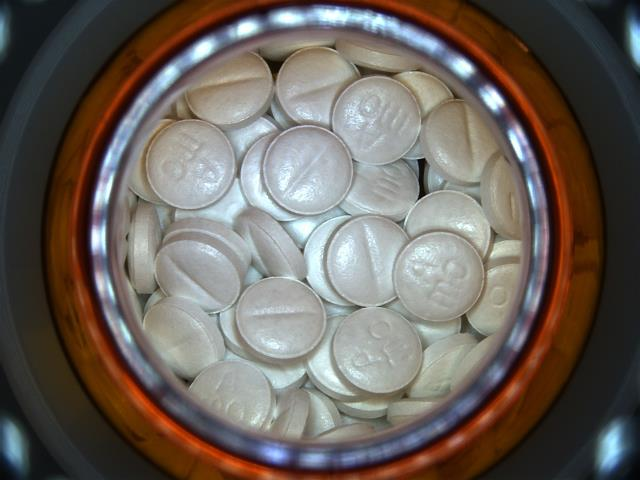

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.9998504
1,1,00591554310,NA,0.0000009
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0001048
3,3,55111039905,NA,0.0000001
4,4,68382041205,Omeprazole,0.0000000
5,5,00781223410,NA,0.0000000
6,6,43547040350,NA,0.0000180
7,7,68382066205,NA,0.0000017
8,8,65862052899,NA,0.0000188
9,9,50111091703,NA,0.0000054


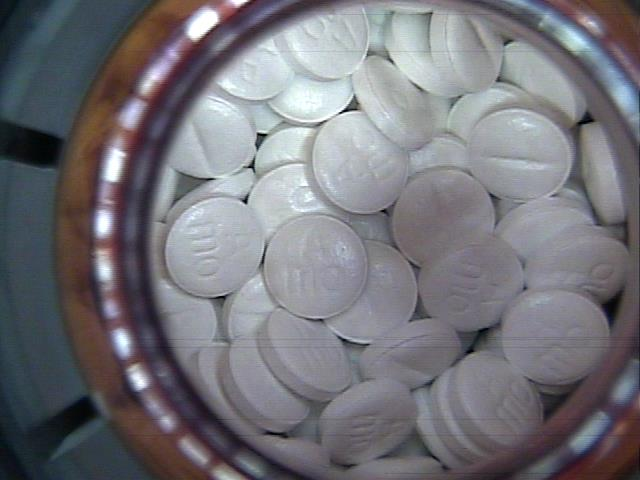

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.9998579
1,1,00591554310,NA,0.0000009
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0000840
3,3,55111039905,NA,0.0000001
4,4,68382041205,Omeprazole,0.0000000
5,5,00781223410,NA,0.0000000
6,6,43547040350,NA,0.0000249
7,7,68382066205,NA,0.0000047
8,8,65862052899,NA,0.0000191
9,9,50111091703,NA,0.0000083


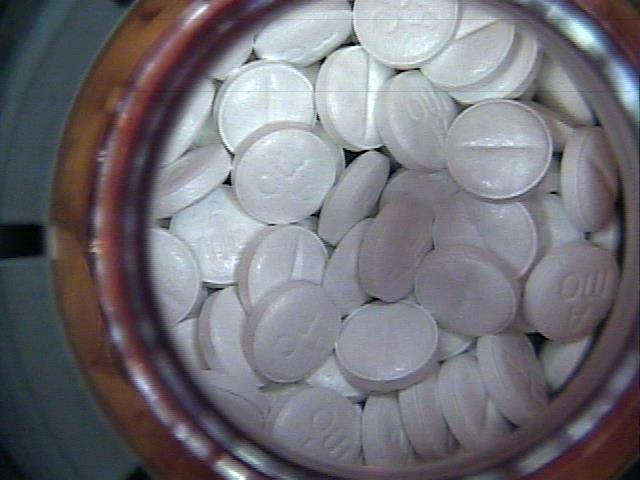

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.0003319
1,1,00591554310,NA,0.0001211
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0006568
3,3,55111039905,NA,0.0000068
4,4,68382041205,Omeprazole,0.9934836
5,5,00781223410,NA,0.0053607
6,6,43547040350,NA,0.0000014
7,7,68382066205,NA,0.0000318
8,8,65862052899,NA,0.0000039
9,9,50111091703,NA,0.0000020


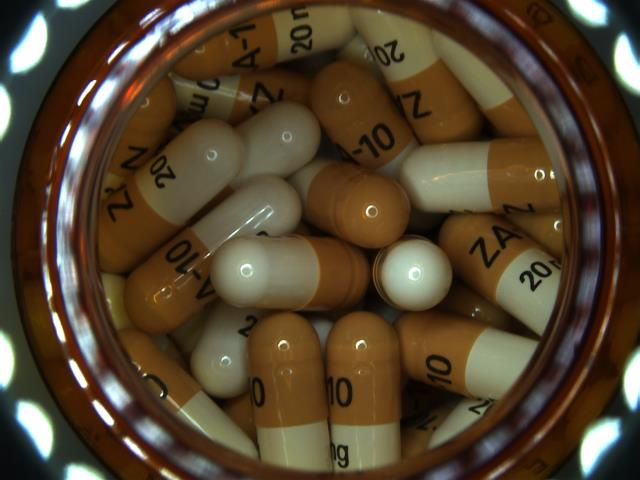

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.9999666
1,1,00591554310,NA,0.0000002
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0000196
3,3,55111039905,NA,0.0000000
4,4,68382041205,Omeprazole,0.0000000
5,5,00781223410,NA,0.0000000
6,6,43547040350,NA,0.0000063
7,7,68382066205,NA,0.0000005
8,8,65862052899,NA,0.0000053
9,9,50111091703,NA,0.0000013


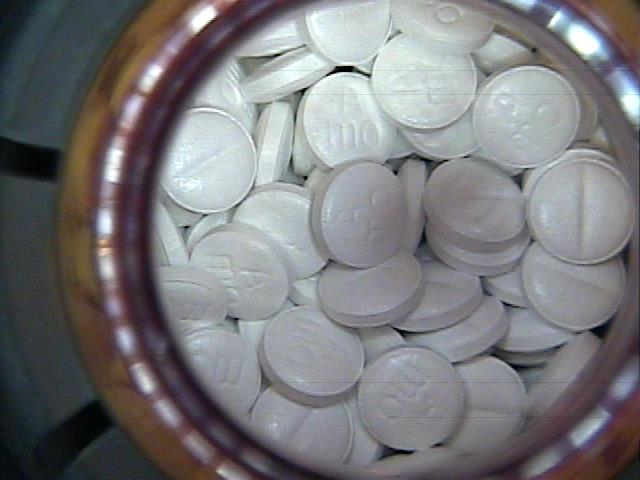

,pill_id,NDC,pill_name,confidence_score
0,0,00527260143,Metoprolol Succinate,0.9998237
1,1,00591554310,NA,0.0000020
2,2,49483062401,Metformin Hydrochloride Extended Release,0.0001238
3,3,55111039905,NA,0.0000001
4,4,68382041205,Omeprazole,0.0000000
5,5,00781223410,NA,0.0000000
6,6,43547040350,NA,0.0000201
7,7,68382066205,NA,0.0000052
8,8,65862052899,NA,0.0000171
9,9,50111091703,NA,0.0000079


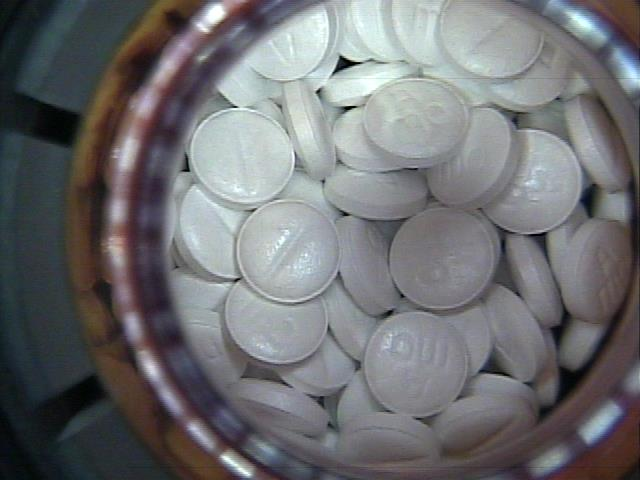

In [43]:
#loops through testing set
count = 0
for i in test_files:
    if count > 7:
        break
    prediction = predict_pill_categorical(i, ResNet50_model)
    count = count+1